In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML

HTML("""
    <style>
    .jp-Stdin-input {
        width: 80% !important;
        height : 1.5em !important;
        font-size : 1em;
        background : white;
        border:1px solid #cccccc;
    }
    </style>
    """)

In [2]:
import numpy as np
import torch
torch.cuda.set_device(1)
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
from Utils import *

In [3]:
torch.cuda.set_device(0)

In [4]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [5]:
vec = pickle.load(open('preprocess/sim_data.p', 'rb'))
add_frequencies(vec, vec.seq_text['train'])

In [6]:
import model.Attn_Word_Pert as M
Model = M.Model

In [7]:
X, Xt = vec.seq_text['train'], vec.seq_text['test']
y, yt = vec.label['train'], vec.label['test']

In [8]:
from sklearn.metrics import classification_report, f1_score

def train(name='') :
    model = Model(vec.vocab_size, vec.word_dim, 64, dirname='sim', hidden_size=6)
    best_f1 = 0.0
    for i in tqdm_notebook(range(30)) :
        loss = model.train(X, y)
        o, he = model.evaluate(Xt)
        o = np.array(o)
        rep = classification_report(yt, (o > 0.5))
        f1 = f1_score(yt, (o > 0.5), pos_label=1)
        print(rep)
        stmt = '%s, %s' % (i, loss)
        if True : #f1 > best_f1 :
            best_f1 = f1
            dirname = model.save_values(add_name=name, save_model=True)
            print("Model Saved", f1)
        else :
            dirname = model.save_values(add_name=name, save_model=False)
            print("Model not saved", f1)
        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    return model

In [11]:
for i in range(10) :
    train(name='TEST_sim_exp_' + str(i))

              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.50      0.03      0.05        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.50      0.40       100
weighted avg       0.57      0.61      0.48       100

Model Saved 0.048780487804878044


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.50      0.03      0.05        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.50      0.40       100
weighted avg       0.57      0.61      0.48       100

Model Saved 0.048780487804878044


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.50      0.03      0.05        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.50      0.40       100
weighted avg       0.57      0.61      0.48       100

Model Saved 0.048780487804878044


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.50      0.03      0.05        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.50      0.40       100
weighted avg       0.57      0.61      0.48       100

Model Saved 0.048780487804878044


              precision    recall  f1-score   support

           0       0.61      0.97      0.75        61
           1       0.50      0.05      0.09        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.51      0.42       100
weighted avg       0.57      0.61      0.49       100

Model Saved 0.09302325581395347


              precision    recall  f1-score   support

           0       0.63      0.97      0.76        61
           1       0.67      0.10      0.18        39

   micro avg       0.63      0.63      0.63       100
   macro avg       0.65      0.53      0.47       100
weighted avg       0.64      0.63      0.53       100

Model Saved 0.17777777777777778


              precision    recall  f1-score   support

           0       0.66      0.97      0.78        61
           1       0.80      0.21      0.33        39

   micro avg       0.67      0.67      0.67       100
   macro avg       0.73      0.59      0.55       100
weighted avg       0.71      0.67      0.60       100

Model Saved 0.326530612244898


              precision    recall  f1-score   support

           0       0.66      0.95      0.78        61
           1       0.75      0.23      0.35        39

   micro avg       0.67      0.67      0.67       100
   macro avg       0.70      0.59      0.57       100
weighted avg       0.69      0.67      0.61       100

Model Saved 0.3529411764705882


              precision    recall  f1-score   support

           0       0.65      0.89      0.75        61
           1       0.59      0.26      0.36        39

   micro avg       0.64      0.64      0.64       100
   macro avg       0.62      0.57      0.55       100
weighted avg       0.63      0.64      0.60       100

Model Saved 0.35714285714285715


              precision    recall  f1-score   support

           0       0.67      0.92      0.78        61
           1       0.71      0.31      0.43        39

   micro avg       0.68      0.68      0.68       100
   macro avg       0.69      0.61      0.60       100
weighted avg       0.69      0.68      0.64       100

Model Saved 0.42857142857142866


              precision    recall  f1-score   support

           0       0.67      0.85      0.75        61
           1       0.59      0.33      0.43        39

   micro avg       0.65      0.65      0.65       100
   macro avg       0.63      0.59      0.59       100
weighted avg       0.64      0.65      0.62       100

Model Saved 0.4262295081967213


              precision    recall  f1-score   support

           0       0.69      0.90      0.78        61
           1       0.70      0.36      0.47        39

   micro avg       0.69      0.69      0.69       100
   macro avg       0.69      0.63      0.63       100
weighted avg       0.69      0.69      0.66       100

Model Saved 0.4745762711864407


              precision    recall  f1-score   support

           0       0.73      0.90      0.81        61
           1       0.76      0.49      0.59        39

   micro avg       0.74      0.74      0.74       100
   macro avg       0.75      0.69      0.70       100
weighted avg       0.74      0.74      0.72       100

Model Saved 0.59375


              precision    recall  f1-score   support

           0       0.74      0.89      0.81        61
           1       0.74      0.51      0.61        39

   micro avg       0.74      0.74      0.74       100
   macro avg       0.74      0.70      0.71       100
weighted avg       0.74      0.74      0.73       100

Model Saved 0.6060606060606061


              precision    recall  f1-score   support

           0       0.76      0.92      0.83        61
           1       0.81      0.54      0.65        39

   micro avg       0.77      0.77      0.77       100
   macro avg       0.78      0.73      0.74       100
weighted avg       0.78      0.77      0.76       100

Model Saved 0.6461538461538461


              precision    recall  f1-score   support

           0       0.82      0.97      0.89        61
           1       0.93      0.67      0.78        39

   micro avg       0.85      0.85      0.85       100
   macro avg       0.87      0.82      0.83       100
weighted avg       0.86      0.85      0.84       100

Model Saved 0.7761194029850746


              precision    recall  f1-score   support

           0       0.85      0.98      0.91        61
           1       0.97      0.72      0.82        39

   micro avg       0.88      0.88      0.88       100
   macro avg       0.91      0.85      0.87       100
weighted avg       0.89      0.88      0.88       100

Model Saved 0.8235294117647058


              precision    recall  f1-score   support

           0       0.90      1.00      0.95        61
           1       1.00      0.82      0.90        39

   micro avg       0.93      0.93      0.93       100
   macro avg       0.95      0.91      0.92       100
weighted avg       0.94      0.93      0.93       100

Model Saved 0.9014084507042254


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        61
           1       1.00      0.90      0.95        39

   micro avg       0.96      0.96      0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100

Model Saved 0.945945945945946


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        61
           1       1.00      0.90      0.95        39

   micro avg       0.96      0.96      0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100

Model Saved 0.945945945945946


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        61
           1       1.00      0.95      0.97        39

   micro avg       0.98      0.98      0.98       100
   macro avg       0.98      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100

Model Saved 0.9736842105263158



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.39      1.00      0.56        39

   micro avg       0.39      0.39      0.39       100
   macro avg       0.20      0.50      0.28       100
weighted avg       0.15      0.39      0.22       100

Model Saved 0.5611510791366906


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.50      0.03      0.06        61
           1       0.39      0.95      0.55        39

   micro avg       0.39      0.39      0.39       100
   macro avg       0.44      0.49      0.30       100
weighted avg       0.46      0.39      0.25       100

Model Saved 0.548148148148148


              precision    recall  f1-score   support

           0       0.70      0.31      0.43        61
           1       0.42      0.79      0.55        39

   micro avg       0.50      0.50      0.50       100
   macro avg       0.56      0.55      0.49       100
weighted avg       0.59      0.50      0.48       100

Model Saved 0.5535714285714286


              precision    recall  f1-score   support

           0       0.59      0.74      0.66        61
           1       0.33      0.21      0.25        39

   micro avg       0.53      0.53      0.53       100
   macro avg       0.46      0.47      0.46       100
weighted avg       0.49      0.53      0.50       100

Model Saved 0.25396825396825395


              precision    recall  f1-score   support

           0       0.62      0.93      0.75        61
           1       0.50      0.10      0.17        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.52      0.46       100
weighted avg       0.57      0.61      0.52       100

Model Saved 0.1702127659574468


              precision    recall  f1-score   support

           0       0.62      0.95      0.75        61
           1       0.50      0.08      0.13        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.51      0.44       100
weighted avg       0.57      0.61      0.51       100

Model Saved 0.13333333333333336


              precision    recall  f1-score   support

           0       0.61      0.97      0.75        61
           1       0.33      0.03      0.05        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.47      0.50      0.40       100
weighted avg       0.50      0.60      0.47       100

Model Saved 0.047619047619047616


              precision    recall  f1-score   support

           0       0.61      0.97      0.75        61
           1       0.33      0.03      0.05        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.47      0.50      0.40       100
weighted avg       0.50      0.60      0.47       100

Model Saved 0.047619047619047616


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.60      0.97      0.74        61
           1       0.00      0.00      0.00        39

   micro avg       0.59      0.59      0.59       100
   macro avg       0.30      0.48      0.37       100
weighted avg       0.37      0.59      0.45       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.62      0.98      0.76        61
           1       0.67      0.05      0.10        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.64      0.52      0.43       100
weighted avg       0.64      0.62      0.50       100

Model Saved 0.09523809523809523


              precision    recall  f1-score   support

           0       0.62      0.98      0.76        61
           1       0.75      0.08      0.14        39

   micro avg       0.63      0.63      0.63       100
   macro avg       0.69      0.53      0.45       100
weighted avg       0.67      0.63      0.52       100

Model Saved 0.13953488372093026


              precision    recall  f1-score   support

           0       0.67      0.98      0.79        61
           1       0.90      0.23      0.37        39

   micro avg       0.69      0.69      0.69       100
   macro avg       0.78      0.61      0.58       100
weighted avg       0.76      0.69      0.63       100

Model Saved 0.3673469387755102


              precision    recall  f1-score   support

           0       0.66      0.90      0.76        61
           1       0.65      0.28      0.39        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.65      0.59      0.58       100
weighted avg       0.66      0.66      0.62       100

Model Saved 0.3928571428571429


              precision    recall  f1-score   support

           0       0.67      0.85      0.75        61
           1       0.59      0.33      0.43        39

   micro avg       0.65      0.65      0.65       100
   macro avg       0.63      0.59      0.59       100
weighted avg       0.64      0.65      0.62       100

Model Saved 0.4262295081967213


              precision    recall  f1-score   support

           0       0.71      0.77      0.74        61
           1       0.59      0.51      0.55        39

   micro avg       0.67      0.67      0.67       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.66      0.67      0.67       100

Model Saved 0.547945205479452


              precision    recall  f1-score   support

           0       0.73      0.74      0.73        61
           1       0.58      0.56      0.57        39

   micro avg       0.67      0.67      0.67       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.67      0.67      0.67       100

Model Saved 0.5714285714285715


              precision    recall  f1-score   support

           0       0.76      0.72      0.74        61
           1       0.60      0.64      0.62        39

   micro avg       0.69      0.69      0.69       100
   macro avg       0.68      0.68      0.68       100
weighted avg       0.69      0.69      0.69       100

Model Saved 0.617283950617284


              precision    recall  f1-score   support

           0       0.79      0.75      0.77        61
           1       0.64      0.69      0.67        39

   micro avg       0.73      0.73      0.73       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.73      0.73      0.73       100

Model Saved 0.6666666666666666


              precision    recall  f1-score   support

           0       0.83      0.82      0.83        61
           1       0.72      0.74      0.73        39

   micro avg       0.79      0.79      0.79       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.79      0.79      0.79       100

Model Saved 0.7341772151898733


              precision    recall  f1-score   support

           0       0.86      0.89      0.87        61
           1       0.81      0.77      0.79        39

   micro avg       0.84      0.84      0.84       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.84      0.84      0.84       100

Model Saved 0.7894736842105263


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        61
           1       0.90      0.90      0.90        39

   micro avg       0.92      0.92      0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

Model Saved 0.8974358974358975


              precision    recall  f1-score   support

           0       0.92      0.98      0.95        61
           1       0.97      0.87      0.92        39

   micro avg       0.94      0.94      0.94       100
   macro avg       0.95      0.93      0.94       100
weighted avg       0.94      0.94      0.94       100

Model Saved 0.9189189189189189


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        61
           1       1.00      0.87      0.93        39

   micro avg       0.95      0.95      0.95       100
   macro avg       0.96      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100

Model Saved 0.9315068493150686



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.39      1.00      0.56        39

   micro avg       0.39      0.39      0.39       100
   macro avg       0.20      0.50      0.28       100
weighted avg       0.15      0.39      0.22       100

Model Saved 0.5611510791366906


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.39      1.00      0.56        39

   micro avg       0.39      0.39      0.39       100
   macro avg       0.20      0.50      0.28       100
weighted avg       0.15      0.39      0.22       100

Model Saved 0.5611510791366906


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.48      0.18      0.26        61
           1       0.35      0.69      0.47        39

   micro avg       0.38      0.38      0.38       100
   macro avg       0.41      0.44      0.36       100
weighted avg       0.43      0.38      0.34       100

Model Saved 0.46551724137931033


              precision    recall  f1-score   support

           0       0.57      0.64      0.60        61
           1       0.29      0.23      0.26        39

   micro avg       0.48      0.48      0.48       100
   macro avg       0.43      0.44      0.43       100
weighted avg       0.46      0.48      0.47       100

Model Saved 0.2571428571428572


              precision    recall  f1-score   support

           0       0.61      0.92      0.73        61
           1       0.38      0.08      0.13        39

   micro avg       0.59      0.59      0.59       100
   macro avg       0.49      0.50      0.43       100
weighted avg       0.52      0.59      0.50       100

Model Saved 0.12765957446808512


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.50      0.03      0.05        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.50      0.40       100
weighted avg       0.57      0.61      0.48       100

Model Saved 0.048780487804878044


              precision    recall  f1-score   support

           0       0.61      0.97      0.75        61
           1       0.33      0.03      0.05        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.47      0.50      0.40       100
weighted avg       0.50      0.60      0.47       100

Model Saved 0.047619047619047616


              precision    recall  f1-score   support

           0       0.60      0.93      0.73        61
           1       0.20      0.03      0.05        39

   micro avg       0.58      0.58      0.58       100
   macro avg       0.40      0.48      0.39       100
weighted avg       0.44      0.58      0.46       100

Model Saved 0.045454545454545456


              precision    recall  f1-score   support

           0       0.60      0.93      0.73        61
           1       0.20      0.03      0.05        39

   micro avg       0.58      0.58      0.58       100
   macro avg       0.40      0.48      0.39       100
weighted avg       0.44      0.58      0.46       100

Model Saved 0.045454545454545456


              precision    recall  f1-score   support

           0       0.61      0.89      0.72        61
           1       0.42      0.13      0.20        39

   micro avg       0.59      0.59      0.59       100
   macro avg       0.52      0.51      0.46       100
weighted avg       0.54      0.59      0.52       100

Model Saved 0.196078431372549


              precision    recall  f1-score   support

           0       0.62      0.87      0.73        61
           1       0.47      0.18      0.26        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.55      0.52      0.49       100
weighted avg       0.56      0.60      0.54       100

Model Saved 0.25925925925925924


              precision    recall  f1-score   support

           0       0.63      0.82      0.71        61
           1       0.48      0.26      0.33        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.55      0.54      0.52       100
weighted avg       0.57      0.60      0.57       100

Model Saved 0.3333333333333333


              precision    recall  f1-score   support

           0       0.65      0.77      0.71        61
           1       0.50      0.36      0.42        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.58      0.56      0.56       100
weighted avg       0.59      0.61      0.59       100

Model Saved 0.417910447761194


              precision    recall  f1-score   support

           0       0.70      0.79      0.74        61
           1       0.58      0.46      0.51        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.64      0.62      0.63       100
weighted avg       0.65      0.66      0.65       100

Model Saved 0.5142857142857143


              precision    recall  f1-score   support

           0       0.72      0.82      0.77        61
           1       0.65      0.51      0.57        39

   micro avg       0.70      0.70      0.70       100
   macro avg       0.68      0.67      0.67       100
weighted avg       0.69      0.70      0.69       100

Model Saved 0.5714285714285714


              precision    recall  f1-score   support

           0       0.74      0.80      0.77        61
           1       0.65      0.56      0.60        39

   micro avg       0.71      0.71      0.71       100
   macro avg       0.69      0.68      0.69       100
weighted avg       0.71      0.71      0.71       100

Model Saved 0.6027397260273972


              precision    recall  f1-score   support

           0       0.77      0.84      0.80        61
           1       0.71      0.62      0.66        39

   micro avg       0.75      0.75      0.75       100
   macro avg       0.74      0.73      0.73       100
weighted avg       0.75      0.75      0.75       100

Model Saved 0.6575342465753424


              precision    recall  f1-score   support

           0       0.88      0.85      0.87        61
           1       0.78      0.82      0.80        39

   micro avg       0.84      0.84      0.84       100
   macro avg       0.83      0.84      0.83       100
weighted avg       0.84      0.84      0.84       100

Model Saved 0.8


              precision    recall  f1-score   support

           0       0.95      0.90      0.92        61
           1       0.86      0.92      0.89        39

   micro avg       0.91      0.91      0.91       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Model Saved 0.888888888888889


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        61
           1       0.97      0.97      0.97        39

   micro avg       0.98      0.98      0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Model Saved 0.9743589743589743



              precision    recall  f1-score   support

           0       0.60      0.15      0.24        61
           1       0.39      0.85      0.53        39

   micro avg       0.42      0.42      0.42       100
   macro avg       0.49      0.50      0.38       100
weighted avg       0.52      0.42      0.35       100

Model Saved 0.532258064516129


              precision    recall  f1-score   support

           0       0.63      0.62      0.63        61
           1       0.42      0.44      0.43        39

   micro avg       0.55      0.55      0.55       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.55      0.55      0.55       100

Model Saved 0.43037974683544306


              precision    recall  f1-score   support

           0       0.60      0.89      0.72        61
           1       0.30      0.08      0.12        39

   micro avg       0.57      0.57      0.57       100
   macro avg       0.45      0.48      0.42       100
weighted avg       0.48      0.57      0.48       100

Model Saved 0.12244897959183675


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.97      0.75        61
           1       0.50      0.05      0.09        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.51      0.42       100
weighted avg       0.57      0.61      0.49       100

Model Saved 0.09302325581395347


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      0.97      0.75        61
           1       0.50      0.05      0.09        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.51      0.42       100
weighted avg       0.57      0.61      0.49       100

Model Saved 0.09302325581395347


              precision    recall  f1-score   support

           0       0.61      0.97      0.75        61
           1       0.50      0.05      0.09        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.51      0.42       100
weighted avg       0.57      0.61      0.49       100

Model Saved 0.09302325581395347


              precision    recall  f1-score   support

           0       0.64      0.97      0.77        61
           1       0.75      0.15      0.26        39

   micro avg       0.65      0.65      0.65       100
   macro avg       0.70      0.56      0.51       100
weighted avg       0.68      0.65      0.57       100

Model Saved 0.25531914893617025


              precision    recall  f1-score   support

           0       0.65      0.97      0.78        61
           1       0.78      0.18      0.29        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.71      0.57      0.53       100
weighted avg       0.70      0.66      0.59       100

Model Saved 0.29166666666666663


              precision    recall  f1-score   support

           0       0.65      0.97      0.78        61
           1       0.78      0.18      0.29        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.71      0.57      0.53       100
weighted avg       0.70      0.66      0.59       100

Model Saved 0.29166666666666663


              precision    recall  f1-score   support

           0       0.67      0.89      0.76        61
           1       0.63      0.31      0.41        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.65      0.60      0.59       100
weighted avg       0.65      0.66      0.63       100

Model Saved 0.41379310344827586


              precision    recall  f1-score   support

           0       0.68      0.89      0.77        61
           1       0.65      0.33      0.44        39

   micro avg       0.67      0.67      0.67       100
   macro avg       0.66      0.61      0.60       100
weighted avg       0.67      0.67      0.64       100

Model Saved 0.4406779661016949


              precision    recall  f1-score   support

           0       0.68      0.89      0.77        61
           1       0.67      0.36      0.47        39

   micro avg       0.68      0.68      0.68       100
   macro avg       0.68      0.62      0.62       100
weighted avg       0.68      0.68      0.65       100

Model Saved 0.4666666666666667


              precision    recall  f1-score   support

           0       0.68      0.85      0.75        61
           1       0.61      0.36      0.45        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.64      0.61      0.60       100
weighted avg       0.65      0.66      0.64       100

Model Saved 0.45161290322580644



              precision    recall  f1-score   support

           0       1.00      0.03      0.06        61
           1       0.40      1.00      0.57        39

   micro avg       0.41      0.41      0.41       100
   macro avg       0.70      0.52      0.32       100
weighted avg       0.77      0.41      0.26       100

Model Saved 0.5693430656934306


              precision    recall  f1-score   support

           0       0.60      0.56      0.58        61
           1       0.37      0.41      0.39        39

   micro avg       0.50      0.50      0.50       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.51      0.50      0.50       100

Model Saved 0.3902439024390244


              precision    recall  f1-score   support

           0       0.62      0.92      0.74        61
           1       0.44      0.10      0.17        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.53      0.51      0.45       100
weighted avg       0.55      0.60      0.51       100

Model Saved 0.16666666666666666


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.64      0.98      0.77        61
           1       0.83      0.13      0.22        39

   micro avg       0.65      0.65      0.65       100
   macro avg       0.74      0.56      0.50       100
weighted avg       0.71      0.65      0.56       100

Model Saved 0.2222222222222222


              precision    recall  f1-score   support

           0       0.67      0.98      0.79        61
           1       0.90      0.23      0.37        39

   micro avg       0.69      0.69      0.69       100
   macro avg       0.78      0.61      0.58       100
weighted avg       0.76      0.69      0.63       100

Model Saved 0.3673469387755102


              precision    recall  f1-score   support

           0       0.67      0.97      0.79        61
           1       0.83      0.26      0.39        39

   micro avg       0.69      0.69      0.69       100
   macro avg       0.75      0.61      0.59       100
weighted avg       0.73      0.69      0.64       100

Model Saved 0.392156862745098


              precision    recall  f1-score   support

           0       0.68      0.97      0.80        61
           1       0.85      0.28      0.42        39

   micro avg       0.70      0.70      0.70       100
   macro avg       0.76      0.62      0.61       100
weighted avg       0.74      0.70      0.65       100

Model Saved 0.4230769230769231


              precision    recall  f1-score   support

           0       0.68      0.97      0.80        61
           1       0.85      0.28      0.42        39

   micro avg       0.70      0.70      0.70       100
   macro avg       0.76      0.62      0.61       100
weighted avg       0.74      0.70      0.65       100

Model Saved 0.4230769230769231


              precision    recall  f1-score   support

           0       0.68      0.97      0.80        61
           1       0.85      0.28      0.42        39

   micro avg       0.70      0.70      0.70       100
   macro avg       0.76      0.62      0.61       100
weighted avg       0.74      0.70      0.65       100

Model Saved 0.4230769230769231


              precision    recall  f1-score   support

           0       0.71      0.97      0.82        61
           1       0.88      0.38      0.54        39

   micro avg       0.74      0.74      0.74       100
   macro avg       0.80      0.68      0.68       100
weighted avg       0.78      0.74      0.71       100

Model Saved 0.5357142857142858


              precision    recall  f1-score   support

           0       0.72      0.97      0.83        61
           1       0.89      0.41      0.56        39

   micro avg       0.75      0.75      0.75       100
   macro avg       0.80      0.69      0.69       100
weighted avg       0.79      0.75      0.72       100

Model Saved 0.5614035087719298


              precision    recall  f1-score   support

           0       0.76      0.93      0.84        61
           1       0.84      0.54      0.66        39

   micro avg       0.78      0.78      0.78       100
   macro avg       0.80      0.74      0.75       100
weighted avg       0.79      0.78      0.77       100

Model Saved 0.6562499999999999


              precision    recall  f1-score   support

           0       0.79      0.97      0.87        61
           1       0.92      0.59      0.72        39

   micro avg       0.82      0.82      0.82       100
   macro avg       0.85      0.78      0.79       100
weighted avg       0.84      0.82      0.81       100

Model Saved 0.71875


              precision    recall  f1-score   support

           0       0.85      0.98      0.91        61
           1       0.97      0.72      0.82        39

   micro avg       0.88      0.88      0.88       100
   macro avg       0.91      0.85      0.87       100
weighted avg       0.89      0.88      0.88       100

Model Saved 0.8235294117647058


              precision    recall  f1-score   support

           0       0.88      1.00      0.94        61
           1       1.00      0.79      0.89        39

   micro avg       0.92      0.92      0.92       100
   macro avg       0.94      0.90      0.91       100
weighted avg       0.93      0.92      0.92       100

Model Saved 0.8857142857142858


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        61
           1       1.00      0.90      0.95        39

   micro avg       0.96      0.96      0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100

Model Saved 0.945945945945946


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.39      1.00      0.56        39

   micro avg       0.39      0.39      0.39       100
   macro avg       0.20      0.50      0.28       100
weighted avg       0.15      0.39      0.22       100

Model Saved 0.5611510791366906


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.62      0.16      0.26        61
           1       0.39      0.85      0.54        39

   micro avg       0.43      0.43      0.43       100
   macro avg       0.51      0.51      0.40       100
weighted avg       0.53      0.43      0.37       100

Model Saved 0.5365853658536585


              precision    recall  f1-score   support

           0       0.57      0.64      0.60        61
           1       0.29      0.23      0.26        39

   micro avg       0.48      0.48      0.48       100
   macro avg       0.43      0.44      0.43       100
weighted avg       0.46      0.48      0.47       100

Model Saved 0.2571428571428572


              precision    recall  f1-score   support

           0       0.59      0.87      0.70        61
           1       0.20      0.05      0.08        39

   micro avg       0.55      0.55      0.55       100
   macro avg       0.39      0.46      0.39       100
weighted avg       0.44      0.55      0.46       100

Model Saved 0.0816326530612245


              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.00      0.00      0.00        39

   micro avg       0.60      0.60      0.60       100
   macro avg       0.30      0.49      0.37       100
weighted avg       0.37      0.60      0.46       100

Model Saved 0.0


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        61
           1       1.00      0.15      0.27        39

   micro avg       0.67      0.67      0.67       100
   macro avg       0.82      0.58      0.53       100
weighted avg       0.79      0.67      0.58       100

Model Saved 0.2666666666666667


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        61
           1       1.00      0.23      0.38        39

   micro avg       0.70      0.70      0.70       100
   macro avg       0.84      0.62      0.59       100
weighted avg       0.80      0.70      0.64       100

Model Saved 0.375


              precision    recall  f1-score   support

           0       0.68      1.00      0.81        61
           1       1.00      0.26      0.41        39

   micro avg       0.71      0.71      0.71       100
   macro avg       0.84      0.63      0.61       100
weighted avg       0.80      0.71      0.65       100

Model Saved 0.4081632653061224


              precision    recall  f1-score   support

           0       0.68      1.00      0.81        61
           1       1.00      0.26      0.41        39

   micro avg       0.71      0.71      0.71       100
   macro avg       0.84      0.63      0.61       100
weighted avg       0.80      0.71      0.65       100

Model Saved 0.4081632653061224


              precision    recall  f1-score   support

           0       0.69      1.00      0.82        61
           1       1.00      0.31      0.47        39

   micro avg       0.73      0.73      0.73       100
   macro avg       0.85      0.65      0.64       100
weighted avg       0.81      0.73      0.68       100

Model Saved 0.47058823529411764


              precision    recall  f1-score   support

           0       0.72      1.00      0.84        61
           1       1.00      0.38      0.56        39

   micro avg       0.76      0.76      0.76       100
   macro avg       0.86      0.69      0.70       100
weighted avg       0.83      0.76      0.73       100

Model Saved 0.5555555555555556


              precision    recall  f1-score   support

           0       0.73      1.00      0.85        61
           1       1.00      0.44      0.61        39

   micro avg       0.78      0.78      0.78       100
   macro avg       0.87      0.72      0.73       100
weighted avg       0.84      0.78      0.75       100

Model Saved 0.6071428571428571


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        61
           1       1.00      0.49      0.66        39

   micro avg       0.80      0.80      0.80       100
   macro avg       0.88      0.74      0.76       100
weighted avg       0.85      0.80      0.78       100

Model Saved 0.6551724137931034


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        61
           1       1.00      0.49      0.66        39

   micro avg       0.80      0.80      0.80       100
   macro avg       0.88      0.74      0.76       100
weighted avg       0.85      0.80      0.78       100

Model Saved 0.6551724137931034


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        61
           1       1.00      0.49      0.66        39

   micro avg       0.80      0.80      0.80       100
   macro avg       0.88      0.74      0.76       100
weighted avg       0.85      0.80      0.78       100

Model Saved 0.6551724137931034


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        61
           1       1.00      0.49      0.66        39

   micro avg       0.80      0.80      0.80       100
   macro avg       0.88      0.74      0.76       100
weighted avg       0.85      0.80      0.78       100

Model Saved 0.6551724137931034


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        61
           1       1.00      0.49      0.66        39

   micro avg       0.80      0.80      0.80       100
   macro avg       0.88      0.74      0.76       100
weighted avg       0.85      0.80      0.78       100

Model Saved 0.6551724137931034


              precision    recall  f1-score   support

           0       0.80      1.00      0.89        61
           1       1.00      0.62      0.76        39

   micro avg       0.85      0.85      0.85       100
   macro avg       0.90      0.81      0.83       100
weighted avg       0.88      0.85      0.84       100

Model Saved 0.761904761904762


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        61
           1       1.00      0.87      0.93        39

   micro avg       0.95      0.95      0.95       100
   macro avg       0.96      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100

Model Saved 0.9315068493150686


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.97      0.99        39

   micro avg       0.99      0.99      0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Model Saved 0.9870129870129869


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.97      0.99        39

   micro avg       0.99      0.99      0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Model Saved 0.9870129870129869


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0



              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.77        61
           1       1.00      0.05      0.10        39

   micro avg       0.63      0.63      0.63       100
   macro avg       0.81      0.53      0.43       100
weighted avg       0.77      0.63      0.51       100

Model Saved 0.09756097560975609


              precision    recall  f1-score   support

           0       0.62      0.98      0.76        61
           1       0.67      0.05      0.10        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.64      0.52      0.43       100
weighted avg       0.64      0.62      0.50       100

Model Saved 0.09523809523809523


              precision    recall  f1-score   support

           0       0.66      0.93      0.77        61
           1       0.69      0.23      0.35        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.67      0.58      0.56       100
weighted avg       0.67      0.66      0.60       100

Model Saved 0.34615384615384615


              precision    recall  f1-score   support

           0       0.73      0.89      0.80        61
           1       0.73      0.49      0.58        39

   micro avg       0.73      0.73      0.73       100
   macro avg       0.73      0.69      0.69       100
weighted avg       0.73      0.73      0.72       100

Model Saved 0.5846153846153846


              precision    recall  f1-score   support

           0       0.78      0.89      0.83        61
           1       0.77      0.62      0.69        39

   micro avg       0.78      0.78      0.78       100
   macro avg       0.78      0.75      0.76       100
weighted avg       0.78      0.78      0.77       100

Model Saved 0.6857142857142857


              precision    recall  f1-score   support

           0       0.81      0.85      0.83        61
           1       0.75      0.69      0.72        39

   micro avg       0.79      0.79      0.79       100
   macro avg       0.78      0.77      0.78       100
weighted avg       0.79      0.79      0.79       100

Model Saved 0.7199999999999999


              precision    recall  f1-score   support

           0       0.82      0.89      0.85        61
           1       0.79      0.69      0.74        39

   micro avg       0.81      0.81      0.81       100
   macro avg       0.81      0.79      0.80       100
weighted avg       0.81      0.81      0.81       100

Model Saved 0.7397260273972601



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.39      1.00      0.56        39

   micro avg       0.39      0.39      0.39       100
   macro avg       0.20      0.50      0.28       100
weighted avg       0.15      0.39      0.22       100

Model Saved 0.5611510791366906


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.39      1.00      0.56        39

   micro avg       0.39      0.39      0.39       100
   macro avg       0.20      0.50      0.28       100
weighted avg       0.15      0.39      0.22       100

Model Saved 0.5611510791366906


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.60      0.15      0.24        61
           1       0.39      0.85      0.53        39

   micro avg       0.42      0.42      0.42       100
   macro avg       0.49      0.50      0.38       100
weighted avg       0.52      0.42      0.35       100

Model Saved 0.532258064516129


              precision    recall  f1-score   support

           0       0.58      0.64      0.61        61
           1       0.33      0.28      0.31        39

   micro avg       0.50      0.50      0.50       100
   macro avg       0.46      0.46      0.46       100
weighted avg       0.49      0.50      0.49       100

Model Saved 0.3055555555555555


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.63      1.00      0.77        61
           1       1.00      0.08      0.14        39

   micro avg       0.64      0.64      0.64       100
   macro avg       0.81      0.54      0.46       100
weighted avg       0.77      0.64      0.53       100

Model Saved 0.14285714285714288


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        61
           1       1.00      0.10      0.19        39

   micro avg       0.65      0.65      0.65       100
   macro avg       0.82      0.55      0.48       100
weighted avg       0.78      0.65      0.55       100

Model Saved 0.18604651162790695


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        61
           1       1.00      0.13      0.23        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.82      0.56      0.50       100
weighted avg       0.78      0.66      0.57       100

Model Saved 0.22727272727272727


              precision    recall  f1-score   support

           0       0.65      0.98      0.78        61
           1       0.88      0.18      0.30        39

   micro avg       0.67      0.67      0.67       100
   macro avg       0.76      0.58      0.54       100
weighted avg       0.74      0.67      0.59       100

Model Saved 0.2978723404255319


              precision    recall  f1-score   support

           0       0.70      1.00      0.82        61
           1       1.00      0.33      0.50        39

   micro avg       0.74      0.74      0.74       100
   macro avg       0.85      0.67      0.66       100
weighted avg       0.82      0.74      0.70       100

Model Saved 0.5


              precision    recall  f1-score   support

           0       0.85      1.00      0.92        61
           1       1.00      0.72      0.84        39

   micro avg       0.89      0.89      0.89       100
   macro avg       0.92      0.86      0.88       100
weighted avg       0.91      0.89      0.89       100

Model Saved 0.835820895522388


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        61
           1       1.00      0.95      0.97        39

   micro avg       0.98      0.98      0.98       100
   macro avg       0.98      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100

Model Saved 0.9736842105263158


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        61
           1       1.00      0.95      0.97        39

   micro avg       0.98      0.98      0.98       100
   macro avg       0.98      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100

Model Saved 0.9736842105263158


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Model Saved 1.0



              precision    recall  f1-score   support

           0       0.61      0.98      0.75        61
           1       0.50      0.03      0.05        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.56      0.50      0.40       100
weighted avg       0.57      0.61      0.48       100

Model Saved 0.048780487804878044


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.63      0.98      0.77        61
           1       0.80      0.10      0.18        39

   micro avg       0.64      0.64      0.64       100
   macro avg       0.72      0.54      0.48       100
weighted avg       0.70      0.64      0.54       100

Model Saved 0.18181818181818182


              precision    recall  f1-score   support

           0       0.63      0.98      0.77        61
           1       0.80      0.10      0.18        39

   micro avg       0.64      0.64      0.64       100
   macro avg       0.72      0.54      0.48       100
weighted avg       0.70      0.64      0.54       100

Model Saved 0.18181818181818182


              precision    recall  f1-score   support

           0       0.65      0.97      0.78        61
           1       0.78      0.18      0.29        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.71      0.57      0.53       100
weighted avg       0.70      0.66      0.59       100

Model Saved 0.29166666666666663


              precision    recall  f1-score   support

           0       0.69      0.97      0.80        61
           1       0.86      0.31      0.45        39

   micro avg       0.71      0.71      0.71       100
   macro avg       0.77      0.64      0.63       100
weighted avg       0.75      0.71      0.67       100

Model Saved 0.45283018867924535


              precision    recall  f1-score   support

           0       0.69      0.97      0.81        61
           1       0.87      0.33      0.48        39

   micro avg       0.72      0.72      0.72       100
   macro avg       0.78      0.65      0.64       100
weighted avg       0.76      0.72      0.68       100

Model Saved 0.48148148148148145


              precision    recall  f1-score   support

           0       0.72      0.97      0.83        61
           1       0.89      0.41      0.56        39

   micro avg       0.75      0.75      0.75       100
   macro avg       0.80      0.69      0.69       100
weighted avg       0.79      0.75      0.72       100

Model Saved 0.5614035087719298


              precision    recall  f1-score   support

           0       0.73      0.97      0.83        61
           1       0.89      0.44      0.59        39

   micro avg       0.76      0.76      0.76       100
   macro avg       0.81      0.70      0.71       100
weighted avg       0.79      0.76      0.74       100

Model Saved 0.5862068965517242


              precision    recall  f1-score   support

           0       0.73      0.97      0.83        61
           1       0.89      0.44      0.59        39

   micro avg       0.76      0.76      0.76       100
   macro avg       0.81      0.70      0.71       100
weighted avg       0.79      0.76      0.74       100

Model Saved 0.5862068965517242


              precision    recall  f1-score   support

           0       0.76      1.00      0.87        61
           1       1.00      0.51      0.68        39

   micro avg       0.81      0.81      0.81       100
   macro avg       0.88      0.76      0.77       100
weighted avg       0.86      0.81      0.79       100

Model Saved 0.6779661016949152


              precision    recall  f1-score   support

           0       0.75      0.98      0.85        61
           1       0.95      0.49      0.64        39

   micro avg       0.79      0.79      0.79       100
   macro avg       0.85      0.74      0.75       100
weighted avg       0.83      0.79      0.77       100

Model Saved 0.6440677966101694


              precision    recall  f1-score   support

           0       0.76      0.98      0.86        61
           1       0.95      0.51      0.67        39

   micro avg       0.80      0.80      0.80       100
   macro avg       0.86      0.75      0.76       100
weighted avg       0.83      0.80      0.78       100

Model Saved 0.6666666666666666


              precision    recall  f1-score   support

           0       0.78      1.00      0.88        61
           1       1.00      0.56      0.72        39

   micro avg       0.83      0.83      0.83       100
   macro avg       0.89      0.78      0.80       100
weighted avg       0.87      0.83      0.82       100

Model Saved 0.7213114754098361


              precision    recall  f1-score   support

           0       0.87      0.97      0.91        61
           1       0.94      0.77      0.85        39

   micro avg       0.89      0.89      0.89       100
   macro avg       0.90      0.87      0.88       100
weighted avg       0.89      0.89      0.89       100

Model Saved 0.8450704225352113


              precision    recall  f1-score   support

           0       0.90      1.00      0.95        61
           1       1.00      0.82      0.90        39

   micro avg       0.93      0.93      0.93       100
   macro avg       0.95      0.91      0.92       100
weighted avg       0.94      0.93      0.93       100

Model Saved 0.9014084507042254


              precision    recall  f1-score   support

           0       0.95      0.98      0.97        61
           1       0.97      0.92      0.95        39

   micro avg       0.96      0.96      0.96       100
   macro avg       0.96      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100

Model Saved 0.9473684210526315


              precision    recall  f1-score   support

           0       0.95      1.00      0.98        61
           1       1.00      0.92      0.96        39

   micro avg       0.97      0.97      0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100

Model Saved 0.9600000000000001



              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        61
           1       0.00      0.00      0.00        39

   micro avg       0.61      0.61      0.61       100
   macro avg       0.30      0.50      0.38       100
weighted avg       0.37      0.61      0.46       100

Model Saved 0.0


/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', averag

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        61
           1       1.00      0.03      0.05        39

   micro avg       0.62      0.62      0.62       100
   macro avg       0.81      0.51      0.41       100
weighted avg       0.77      0.62      0.48       100

Model Saved 0.05


              precision    recall  f1-score   support

           0       0.62      1.00      0.77        61
           1       1.00      0.05      0.10        39

   micro avg       0.63      0.63      0.63       100
   macro avg       0.81      0.53      0.43       100
weighted avg       0.77      0.63      0.51       100

Model Saved 0.09756097560975609


              precision    recall  f1-score   support

           0       0.63      1.00      0.77        61
           1       1.00      0.08      0.14        39

   micro avg       0.64      0.64      0.64       100
   macro avg       0.81      0.54      0.46       100
weighted avg       0.77      0.64      0.53       100

Model Saved 0.14285714285714288


              precision    recall  f1-score   support

           0       0.63      0.98      0.77        61
           1       0.80      0.10      0.18        39

   micro avg       0.64      0.64      0.64       100
   macro avg       0.72      0.54      0.48       100
weighted avg       0.70      0.64      0.54       100

Model Saved 0.18181818181818182


              precision    recall  f1-score   support

           0       0.66      0.98      0.79        61
           1       0.89      0.21      0.33        39

   micro avg       0.68      0.68      0.68       100
   macro avg       0.77      0.59      0.56       100
weighted avg       0.75      0.68      0.61       100

Model Saved 0.3333333333333333


              precision    recall  f1-score   support

           0       0.68      0.98      0.81        61
           1       0.92      0.28      0.43        39

   micro avg       0.71      0.71      0.71       100
   macro avg       0.80      0.63      0.62       100
weighted avg       0.77      0.71      0.66       100

Model Saved 0.4313725490196078


              precision    recall  f1-score   support

           0       0.71      0.98      0.83        61
           1       0.94      0.38      0.55        39

   micro avg       0.75      0.75      0.75       100
   macro avg       0.83      0.68      0.69       100
weighted avg       0.80      0.75      0.72       100

Model Saved 0.5454545454545454


              precision    recall  f1-score   support

           0       0.74      0.98      0.85        61
           1       0.95      0.46      0.62        39

   micro avg       0.78      0.78      0.78       100
   macro avg       0.84      0.72      0.73       100
weighted avg       0.82      0.78      0.76       100

Model Saved 0.6206896551724138


              precision    recall  f1-score   support

           0       0.74      0.87      0.80        61
           1       0.71      0.51      0.60        39

   micro avg       0.73      0.73      0.73       100
   macro avg       0.73      0.69      0.70       100
weighted avg       0.73      0.73      0.72       100

Model Saved 0.5970149253731343


              precision    recall  f1-score   support

           0       0.77      0.87      0.82        61
           1       0.74      0.59      0.66        39

   micro avg       0.76      0.76      0.76       100
   macro avg       0.76      0.73      0.74       100
weighted avg       0.76      0.76      0.75       100

Model Saved 0.6571428571428573


              precision    recall  f1-score   support

           0       0.79      0.87      0.83        61
           1       0.76      0.64      0.69        39

   micro avg       0.78      0.78      0.78       100
   macro avg       0.77      0.75      0.76       100
weighted avg       0.78      0.78      0.78       100

Model Saved 0.6944444444444444


              precision    recall  f1-score   support

           0       0.86      0.93      0.90        61
           1       0.88      0.77      0.82        39

   micro avg       0.87      0.87      0.87       100
   macro avg       0.87      0.85      0.86       100
weighted avg       0.87      0.87      0.87       100

Model Saved 0.8219178082191781



# **EVALUATION**

In [9]:
def load_model(dirname) :
    model = Model(vec.vocab_size, vec.word_dim, 32, dirname='sst', hidden_size=6)
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [12]:
import os
dirs = os.listdir('outputs/attn_word_sim/')
dirs = [d for d in dirs if 'exp' in d]

In [13]:
for e in dirs :
    model = load_model('outputs/attn_word_sim/' + e)
    yt_hat, attn_hat = evaluate_and_print(model, Xt, yt)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        61
           1       1.00      0.95      0.97        39

   micro avg       0.98      0.98      0.98       100
   macro avg       0.98      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        61
           1       1.00      0.87      0.93        39

   micro avg       0.95      0.95      0.95       100
   macro avg       0.96      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100

              precision    recall  f1-score   support

           0       0.68      0.85      0.75        61
           1       0.61      0.36      0.45        39

   micro avg       0.66      0.66      0.66       100
   macro avg       0.64      0.61      0.60       100
weighted avg       0.65      0.66      0.64       100

              preci

In [ ]:
# model = load_model('outputs/attn_word_sim/FriOct1913:14:512018_TEST_sim_exp_2/')

In [14]:
yt_hat, attn_hat = evaluate_and_print(model, Xt, yt)

              precision    recall  f1-score   support

           0       0.86      0.93      0.90        61
           1       0.88      0.77      0.82        39

   micro avg       0.87      0.87      0.87       100
   macro avg       0.87      0.85      0.86       100
weighted avg       0.87      0.87      0.87       100



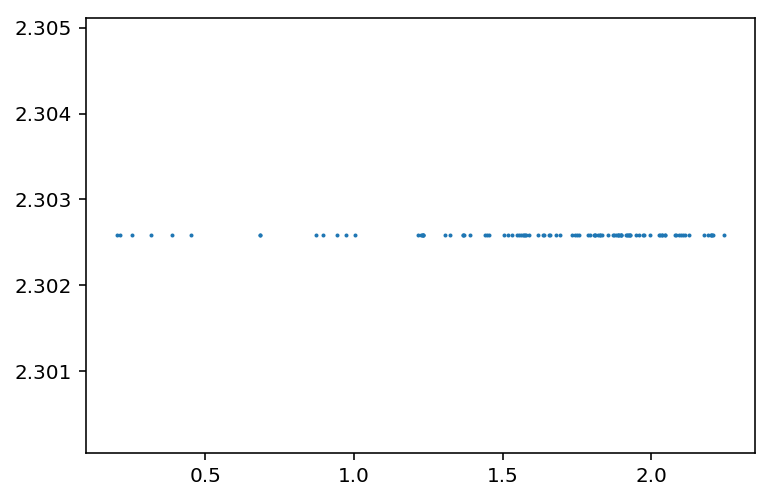

In [15]:
plot_entropy(Xt, attn_hat)

# __Sampling__

In [20]:
model.vec = vec
sampled_output = model.sampling_top(Xt, sample_vocab=min(vec.vocab_size-1, 100), topnum=5)

In [21]:
import pickle
pickle.dump(sampled_output, open(model.dirname + '/sampled.p', 'wb'))

In [22]:
sampled_output = pickle.load(open(model.dirname + '/sampled.p', 'rb'))

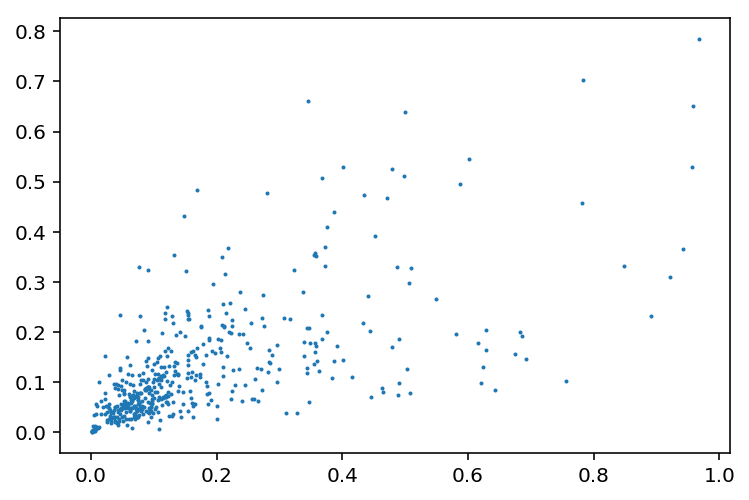

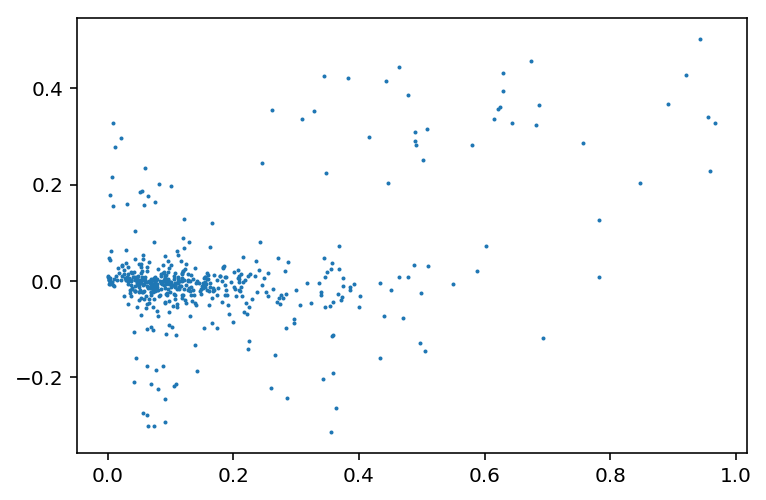

In [23]:
generate_medians_from_sampling_top(sampled_output, attn_hat, yt_hat)

In [24]:
distractors = get_distractors(sampled_output, attn_hat)
print_few_distractors(vec, Xt, attn_hat, sampled_output, distractors)

17.857142857142858 5 28


--------------------


****************************************


--------------------


****************************************


--------------------


****************************************


--------------------


****************************************


--------------------


****************************************


**Gradients**
=============

In [25]:
grads = model.gradient_mem(Xt)
process_grads(grads)

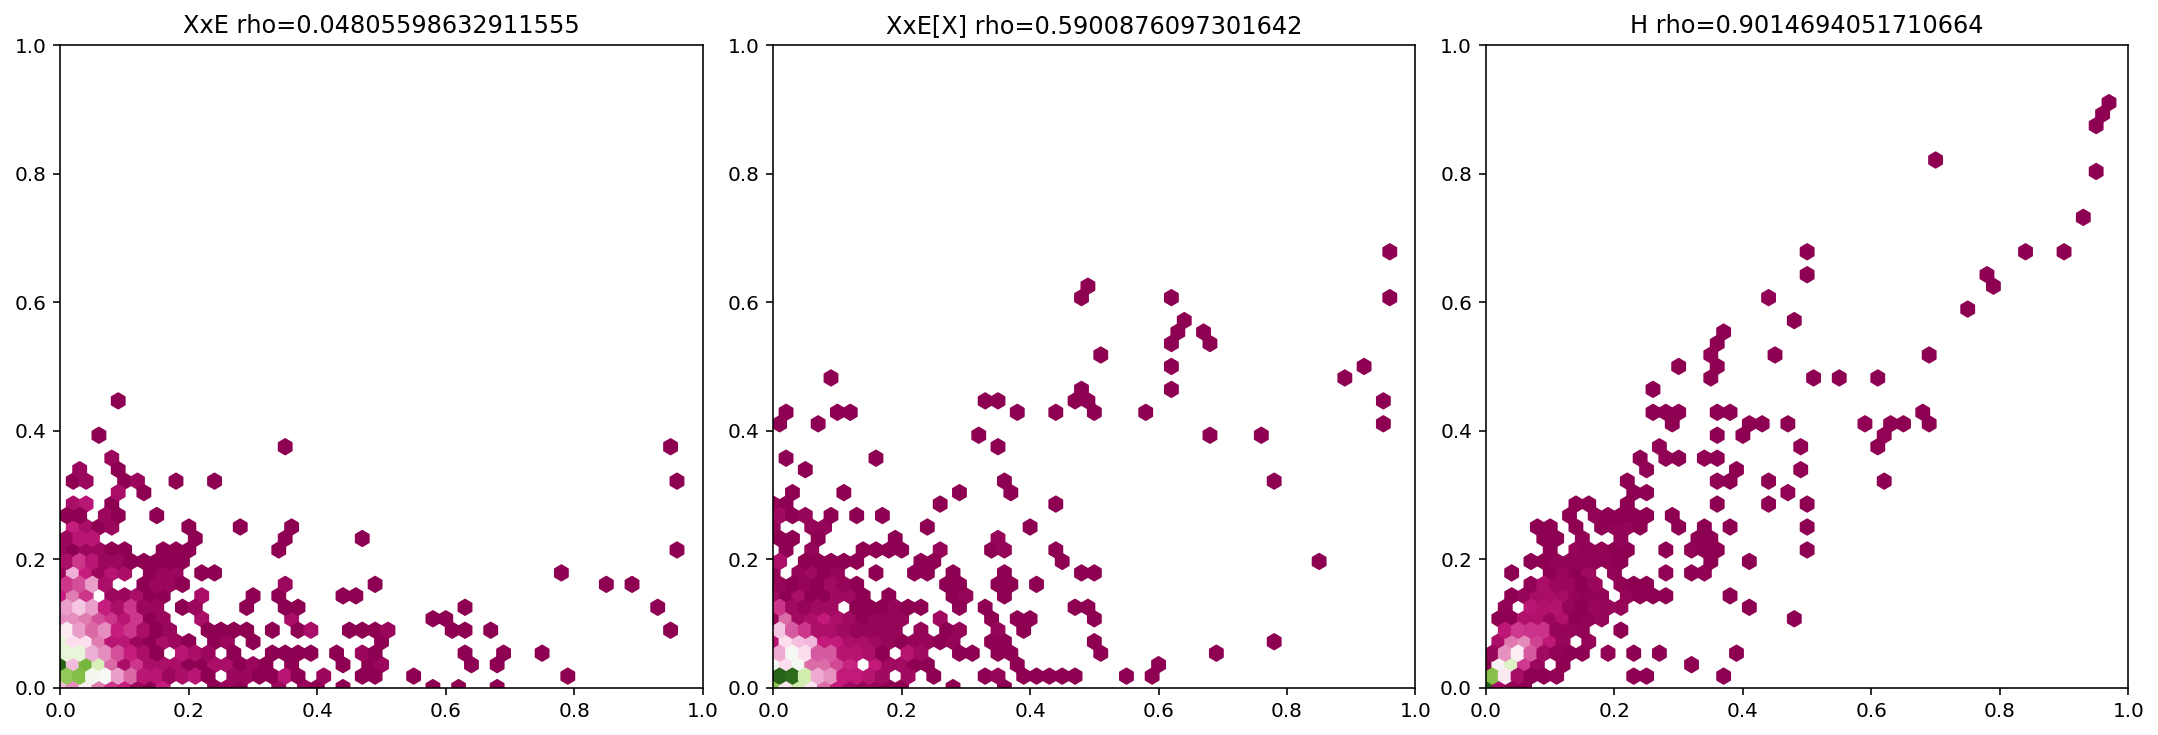

In [26]:
plot_grads(Xt, attn_hat, grads)

**Permutation**
===========

In [27]:
perms = model.permute_attn(Xt)

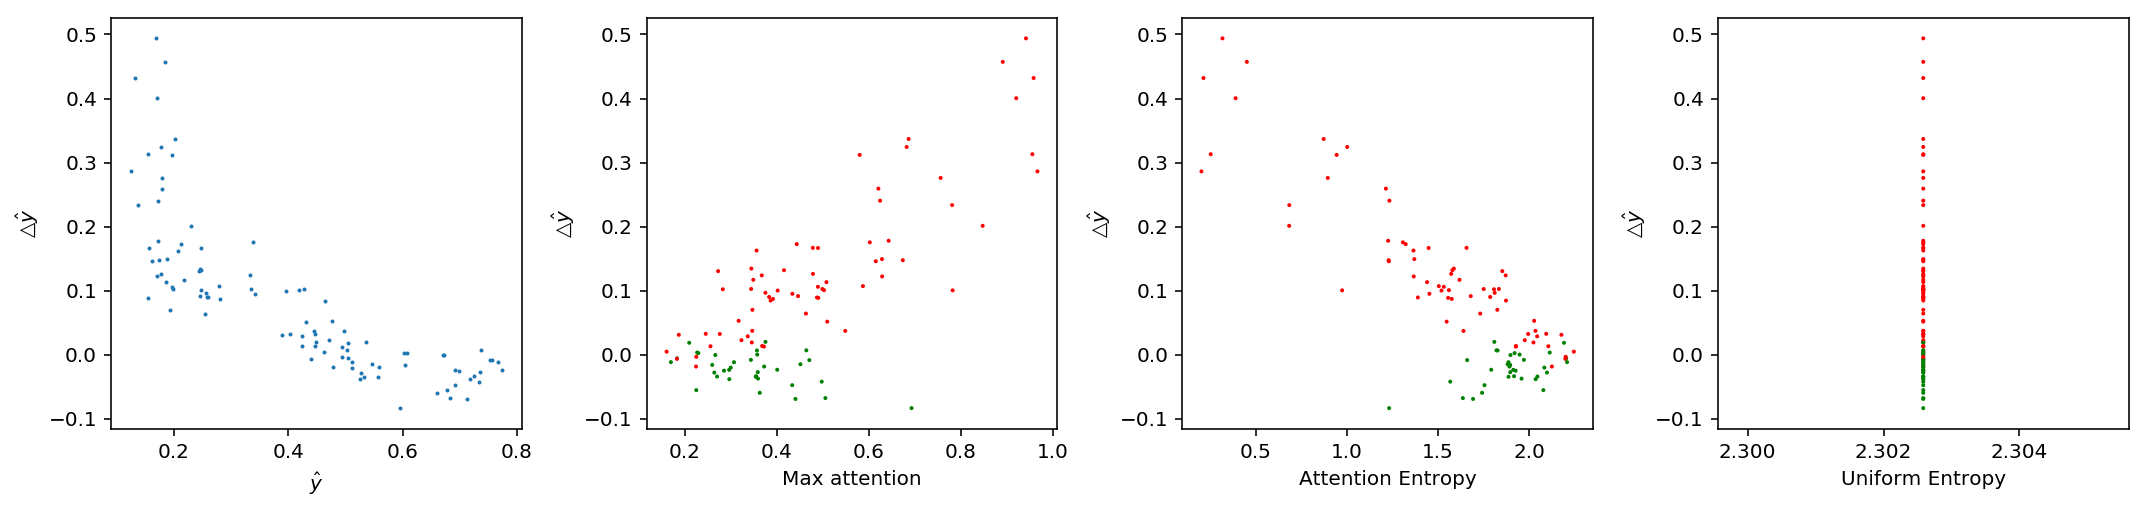

In [28]:
plot_permutations(perms, Xt, yt_hat, attn_hat)

**Adversary**
=============

In [29]:
adversarial_outputs = model.adversarial(Xt, _type='uniform')
ad_y, ad_attn = adversarial_outputs

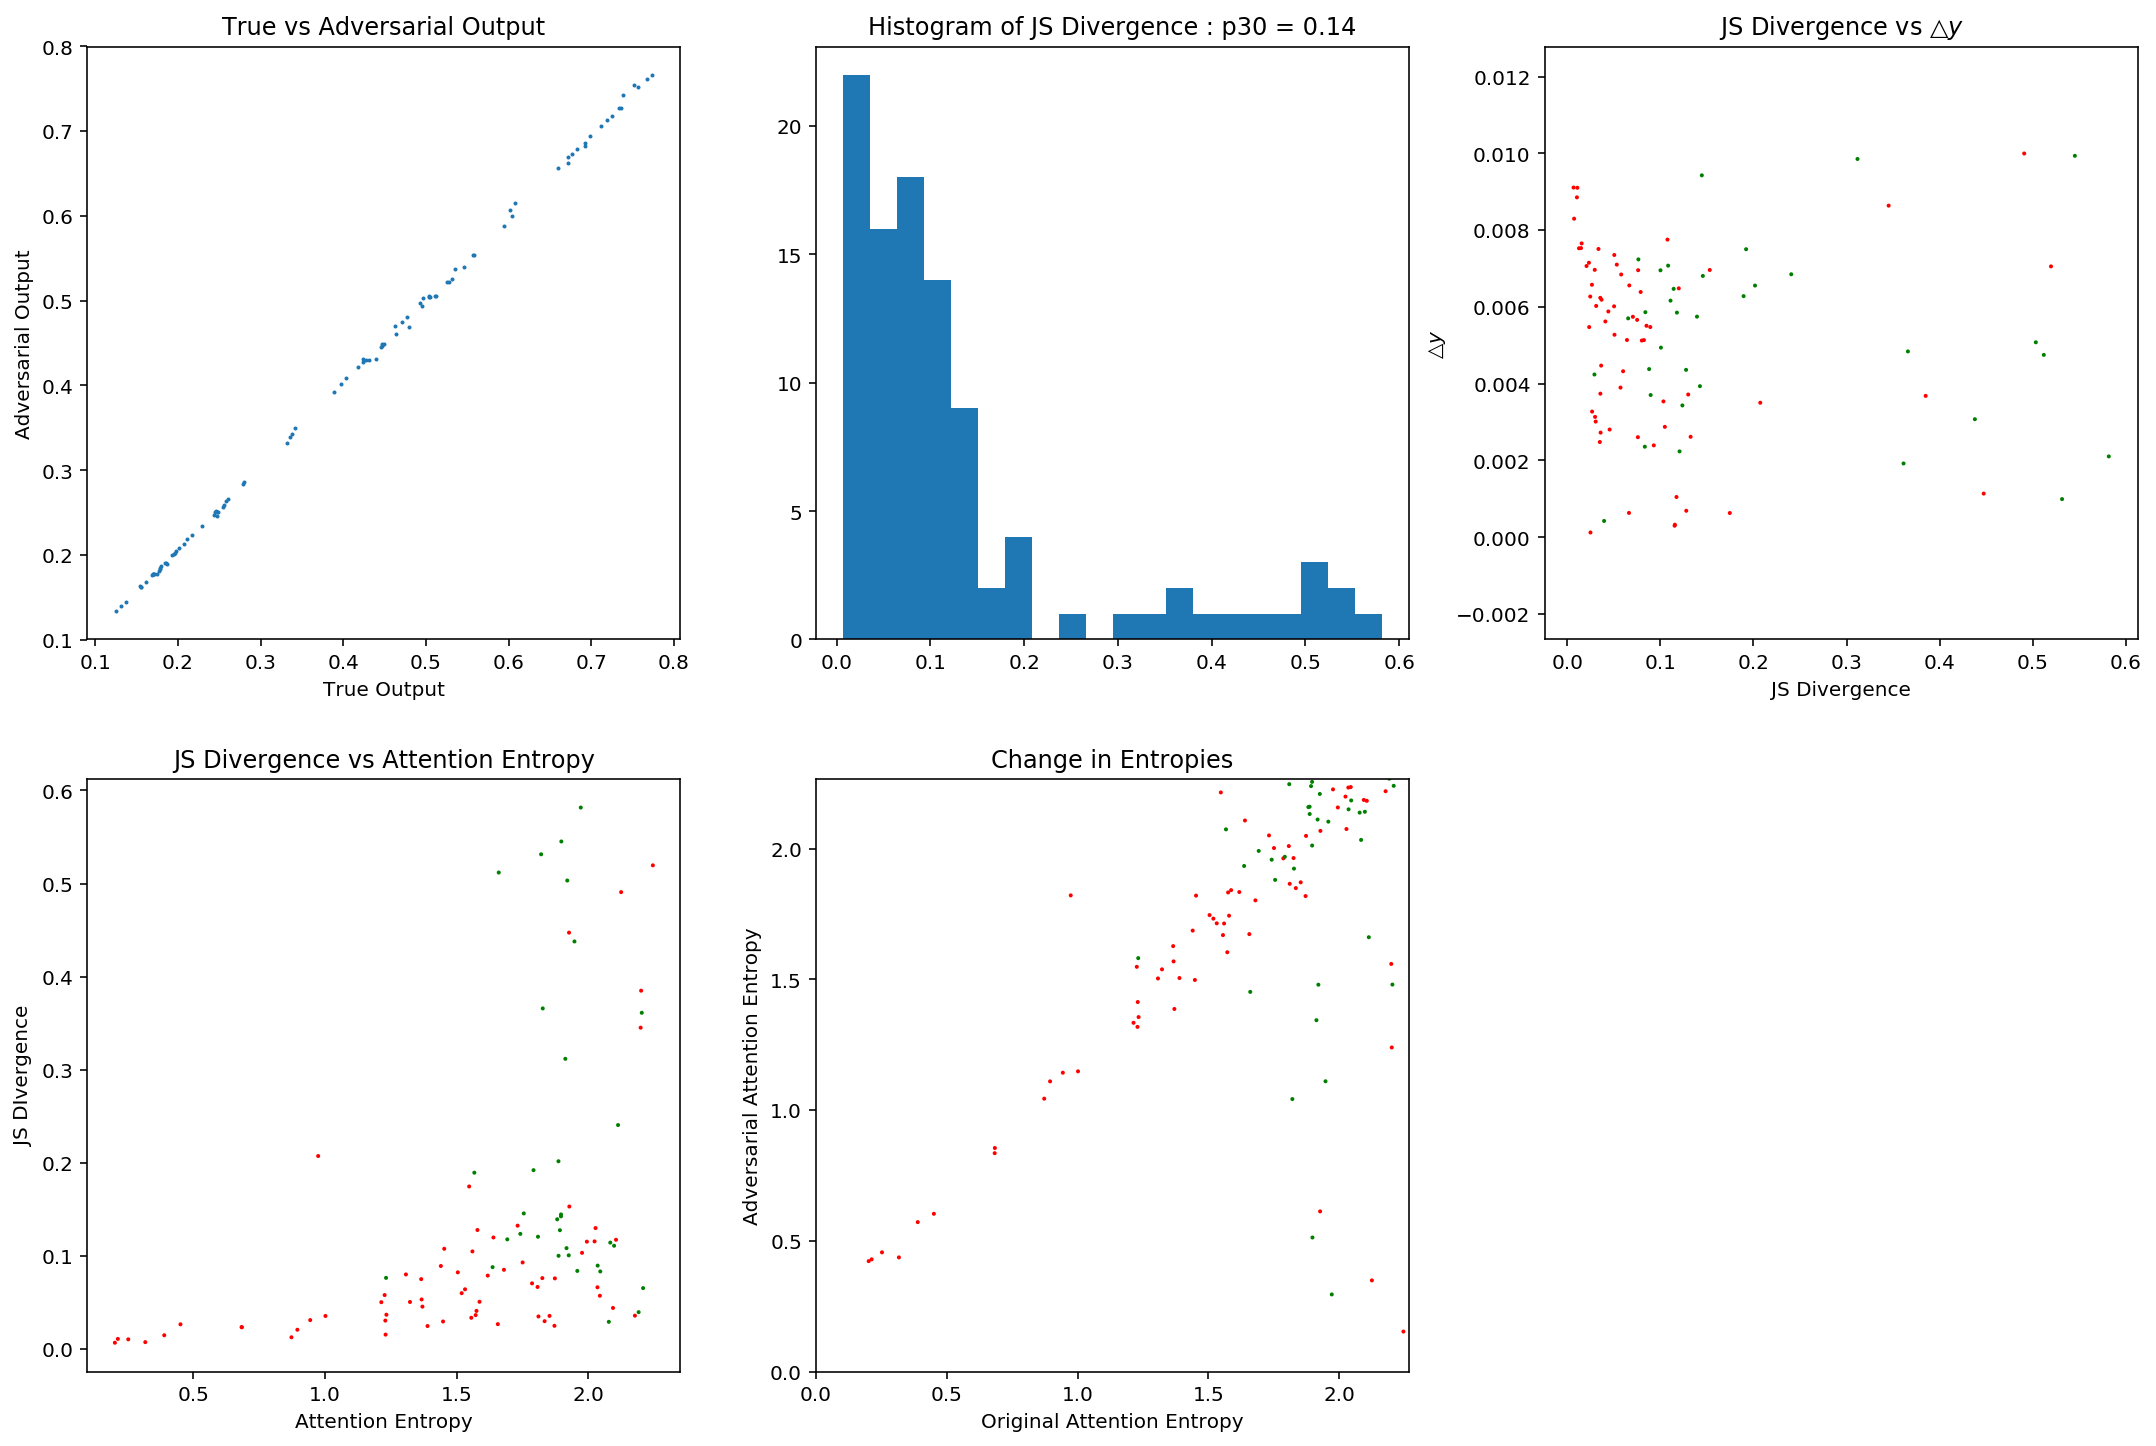

In [30]:
jds = plot_adversarial(Xt, yt_hat, attn_hat, adversarial_outputs)

In [34]:
idx = list(np.where(np.array(jds) > 0.5)[0])[:30]
idx

[20, 26, 45, 53, 83, 88]

In [35]:
n = 45
print_adversarial_example(vec.map2words(X[n]), attn_hat[n], ad_attn[n])
print(yt_hat[n], ad_y[n])

--------------------


0.50352365 [0.5045156]


**Zero Runs**
=============

In [36]:
zero_runs = model.zero_H_run(Xt)

In [37]:
zero_outputs, zero_H_diff = zero_runs

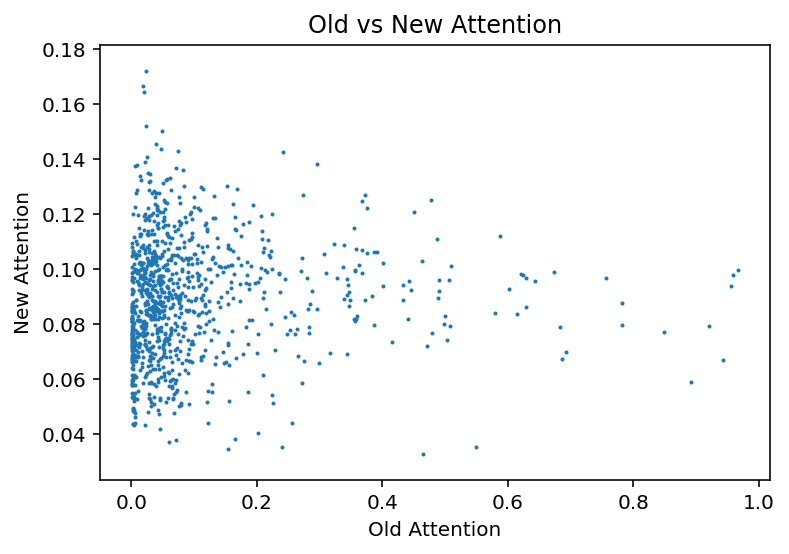

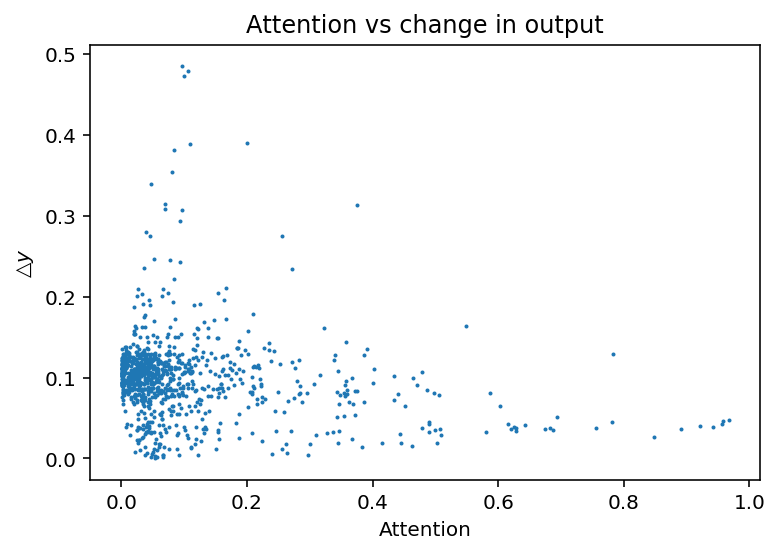

In [38]:
plot_attn_diff(Xt, attn_hat, zero_H_diff)
plot_y_diff(X, attn_hat, yt_hat, zero_outputs)

**Remove and Run**
==================

In [39]:
remove_outputs = model.remove_and_run(Xt)

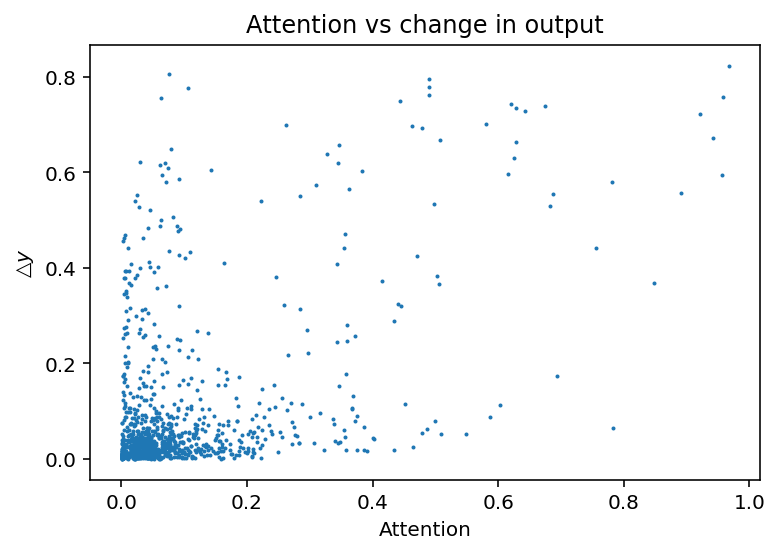

In [40]:
plot_y_diff(Xt, attn_hat, yt_hat, remove_outputs)

**Perturbation**
================

In [41]:
perturb_outputs = model.perturbation_embedding(Xt)

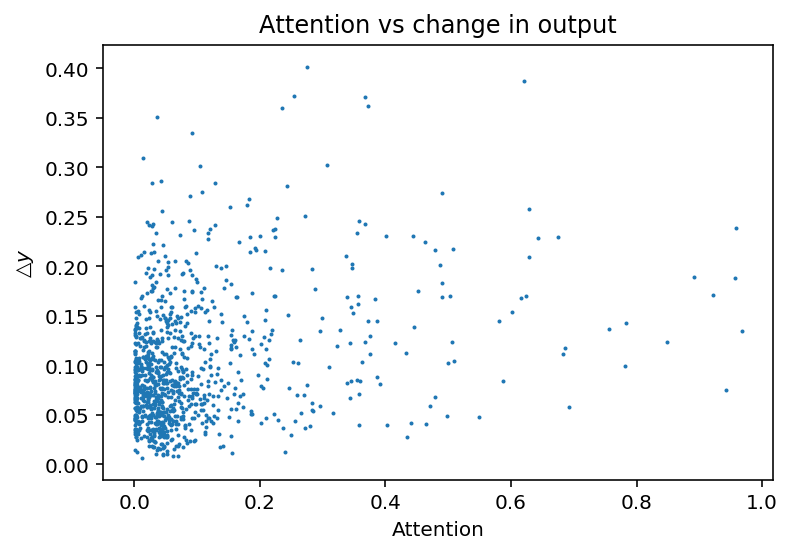

In [42]:
plot_pertub_embedding(Xt, attn_hat, yt_hat, perturb_outputs)